In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time
import joblib
from sklearn.impute import SimpleImputer

In [3]:
df = pd.read_csv("data_teacher_salaries.csv")

In [5]:
# CELL 1: Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv("data_teacher_salaries.csv")
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (12535, 32)

Column names:
['Unnamed: 0.1', 'Unnamed: 0', 'DISTRICT_NUMBER', 'DISTRICT', 'CAMPUS_NUMBER', 'CAMPUS', 'REGION', 'COUNTY', 'SCHOOL_TYPE', 'GRADES_SERVED', 'CHARTER', 'URBANICITY', 'NUMBER_OF_STUDENTS', 'OVERALL_RATING', 'OVERALL_SCORE', '%_ECONOMICALLY_DISADVANTAGED', '%_EB/EL_STUDENTS', 'FREE_LUNCH_QUALIFIED_COUNT', 'REDUCED-PRICE_LUNCH_QUALIFIED_COUNT', 'RACE_AMERICAN_INDIAN_OR_ALASKA_NATIVE', 'RACE_ASIAN', 'RACE_BLACK_OR_AFRICAN_AMERICAN', 'RACE_HISPANIC/LATINO', 'RACE_NATIVE_HAWAIIAN_OR_OTHER_PACIFIC_ISLANDER', 'RACE_TWO_OR_MORE_RACES', 'RACE_WHITE', 'TEACHERS_COUNT', 'LAT', 'LONG', 'MEDIAN_HOUSEHOLD_INCOME_AREA', 'ST_SCHID', 'AVG_TEACHER_SALARY']

First few rows:


,Unnamed: 0.1,Unnamed: 0,DISTRICT_NUMBER,DISTRICT,CAMPUS_NUMBER,CAMPUS,REGION,COUNTY,SCHOOL_TYPE,GRADES_SERVED,...,RACE_HISPANIC/LATINO,RACE_NATIVE_HAWAIIAN_OR_OTHER_PACIFIC_ISLANDER,RACE_TWO_OR_MORE_RACES,RACE_WHITE,TEACHERS_COUNT,LAT,LONG,MEDIAN_HOUSEHOLD_INCOME_AREA,ST_SCHID,AVG_TEACHER_SALARY
0,0,0,1902,CAYUGA ISD,1902001.0,CAYUGA H S,REGION 07: KILGORE,ANDERSON,High School,09 - 12,...,36.0,0.0,16.0,276.0,19.34,31.9569,-95.9744,72483.0,TX-001902-001902001,55570.0
1,1,1,1902,CAYUGA ISD,1902041.0,CAYUGA MIDDLE,REGION 07: KILGORE,ANDERSON,Middle School,06 - 08,...,32.0,0.0,18.0,264.0,11.20,31.9569,-95.9744,72483.0,TX-001902-001902041,55570.0
2,2,2,1902,CAYUGA ISD,1902103.0,CAYUGA EL,REGION 07: KILGORE,ANDERSON,Elementary,PK - 05,...,44.0,0.0,20.0,420.0,17.86,31.9569,-95.9744,72483.0,TX-001902-001902103,55570.0
3,3,3,1903,ELKHART ISD,1903001.0,ELKHART H S,REGION 07: KILGORE,ANDERSON,High School,09 - 12,...,76.0,2.0,20.0,502.0,35.72,31.6275,-95.5785,76397.0,TX-001903-001903001,47916.0
4,4,4,1903,ELKHART ISD,1903041.0,ELKHART MIDDLE,REGION 07: KILGORE,ANDERSON,Middle School,06 - 08,...,62.0,0.0,16.0,442.0,23.82,31.6279,-95.5780,76397.0,TX-001903-001903041,47916.0


In [ ]:
# CELL 2: Setting up the Problem (3 points)
"""
Setting up the problem: We are predicting AVG_TEACHER_SALARY, which is a real-valued continuous outcome.
This is a regression problem where we want to predict the average salary of teachers in a school district.

Target: Real-valued outcome representing average teacher salary in USD (continuous regression)

Feature justification:
- School type, grades served, charter status: Directly impact budget and salary decisions
- Demographics (% economically disadvantaged, race composition): Impact funding and compensation
- Location factors (region, county, urbanicity): Geographic cost of living affects salaries
- Performance metrics (overall rating, score): May influence salary decisions
- Student and teacher counts: Scale factors affecting budget allocation

All features are available before salary decisions are made, avoiding data leakage.
The dataset represents school districts at a point in time, maintaining stationarity.

In [12]:
# CELL 3: Data Preprocessing - FIXED VERSION
def preprocess_data(df):
    df_processed = df.copy()

    # Drop unnecessary identifier columns
    df_processed = df_processed.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, errors='ignore')

    # Separate features and target
    target_col = 'AVG_TEACHER_SALARY'
    X = df_processed.drop(target_col, axis=1)
    y = df_processed[target_col]

    # Remove any rows where target is NaN, infinity, or extremely large
    # First check for problematic values
    print(f"Original target range: {y.min()} to {y.max()}")
    print(f"Target NaN count: {y.isna().sum()}")
    print(f"Target infinite count: {np.isinf(y).sum()}")

    # Remove problematic target values
    mask = ~(y.isna() | np.isinf(y) | (y > 1e10) | (y < 0))  # Remove NaN, inf, very large, negative
    X = X[mask]
    y = y[mask]

    print(f"After cleaning - Target range: {y.min()} to {y.max()}")
    print(f"Remaining samples: {len(y)}")

    # Handle missing values in features
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    categorical_columns = X.select_dtypes(include=['object']).columns

    # Impute numeric columns with median
    imputer_numeric = SimpleImputer(strategy='median')
    X[numeric_columns] = imputer_numeric.fit_transform(X[numeric_columns])

    # Encode categorical variables
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

    return X, y, label_encoders

X, y, encoders = preprocess_data(df)

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Target statistics:", y.describe())

# Now re-split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Original target range: 36081.0 to 110567.0
Target NaN count: 19
Target infinite count: 0
After cleaning - Target range: 36081.0 to 110567.0
Remaining samples: 12516
Features shape: (12516, 29)
Target shape: (12516,)
Target statistics: count     12516.000000
mean      57755.647172
std        5034.934723
min       36081.000000
25%       53993.000000
50%       58215.000000
75%       61811.000000
max      110567.000000
Name: AVG_TEACHER_SALARY, dtype: float64
Training set shape: (10012, 29)
Test set shape: (2504, 29)


In [7]:
# CELL 4: Choice of Model Class and Justification (3 points)
"""
Choice of model class: XGBoost (Extreme Gradient Boosting)

Why XGBoost is appropriate for this task:

1. **Bias-Variance Trade-off**: XGBoost provides excellent balance between bias and variance
   through regularization parameters (reg_alpha, reg_lambda), which is crucial for salary prediction
   where we want to capture complex relationships without overfitting.

2. **Non-linearity and Interactions**: Teacher salaries depend on complex interactions between
   demographics, location, school type, and performance metrics. XGBoost naturally captures
   these non-linear relationships and feature interactions.

3. **Robustness to Outliers**: School districts with extremely high or low salaries are handled
   well by XGBoost's gradient-based optimization.

4. **Feature Importance**: XGBoost provides clear feature importance rankings, helping understand
   which factors most influence teacher salaries.

5. **Performance on Tabular Data**: XGBoost consistently outperforms other algorithms on
   tabular datasets like this one, as demonstrated in numerous Kaggle competitions.

6. **Regularization**: Built-in L1 and L2 regularization prevents overfitting, important
   given the number of features relative to observations.

7. **Handling Mixed Data Types**: Works well with the mixed categorical and numerical features
   after encoding, without requiring extensive preprocessing.

Compared to Random Forest, XGBoost typically provides superior predictive performance
on tabular data while maintaining interpretability through feature importance.

"""

"\nChoice of model class: XGBoost (Extreme Gradient Boosting)\n\nWhy XGBoost is appropriate for this task:\n\n1. **Bias-Variance Trade-off**: XGBoost provides excellent balance between bias and variance\n   through regularization parameters (reg_alpha, reg_lambda), which is crucial for salary prediction\n   where we want to capture complex relationships without overfitting.\n\n2. **Non-linearity and Interactions**: Teacher salaries depend on complex interactions between\n   demographics, location, school type, and performance metrics. XGBoost naturally captures\n   these non-linear relationships and feature interactions.\n\n3. **Robustness to Outliers**: School districts with extremely high or low salaries are handled\n   well by XGBoost's gradient-based optimization.\n\n4. **Feature Importance**: XGBoost provides clear feature importance rankings, helping understand\n   which factors most influence teacher salaries.\n\n5. **Performance on Tabular Data**: XGBoost consistently outperfor

In [8]:
# CELL 5: Data Splitting and Validation Strategy (3 points)
"""
Evaluation and validation procedure:

Data Split Strategy: 80% training, 20% testing split to maintain sufficient data for training
while having a robust test set for unbiased evaluation.

Why this approach:
- Maintains i.i.d. assumption as each school district is an independent observation
- Provides sufficient training data for XGBoost to learn complex patterns
- Test set remains completely untouched during model development to avoid data leakage
- No temporal ordering in the data, so simple random split is appropriate

Metric Choice:
- RMSE (Root Mean Squared Error): Appropriate for salary prediction as it penalizes
  larger errors more heavily and is in the same units as the target ($)
- R² (Coefficient of Determination): Shows proportion of variance explained
- MAE (Mean Absolute Error): Provides intuitive average prediction error

These metrics are justified because:
- RMSE is sensitive to outliers which is important for salary ranges
- MAE gives interpretable average error in dollars
- R² indicates model explanatory power
"""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (10028, 29)
Test set shape: (2507, 29)


In [13]:
# CELL 6: Hyperparameter Tuning and Loss Function (3 points) - Fixed version
"""
Choice of hyperparameters and loss function:

Loss Function: 'reg:squarederror' (squared loss) is appropriate for regression tasks
as it minimizes the mean squared error, providing optimal predictions under normal
error assumptions.

Key hyperparameters tuned:
- max_depth: Maximum tree depth (3, 6) - prevents overfitting through depth control
- learning_rate: Step size shrinkage (0.05, 0.1) - regularization through slower learning

We use a conservative approach to avoid configuration issues while still finding
optimal parameters for the salary prediction task.

Search Method: Grid search with 3-fold cross-validation to systematically explore
the hyperparameter space while maintaining computational efficiency.
"""

# Test that the cleaned data works
print("Testing basic XGBoost model with cleaned data...")
xgb_basic = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    eval_metric='rmse'
)

xgb_basic.fit(X_train, y_train)
print("Basic model trained successfully!")

# Now perform hyperparameter tuning with a simplified grid
xgb_param_grid = {
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1]
}

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    random_state=42,
    eval_metric='rmse'
)

print("Performing hyperparameter tuning...")
xgb_grid_search = GridSearchCV(
    xgb_model,
    xgb_param_grid,
    cv=3,  # Reduce CV folds to 3 to speed up and reduce memory usage
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

xgb_grid_search.fit(X_train, y_train)

# Get best XGBoost model
xgb_best = xgb_grid_search.best_estimator_
print("Best XGBoost parameters:", xgb_grid_search.best_params_)

Testing basic XGBoost model with cleaned data...
Basic model trained successfully!
Performing hyperparameter tuning...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 6}


In [14]:
# CELL 7: Model Evaluation and Energy Usage (3 points)
"""
Evaluation and conclusion including energy usage:

Results presented with uncertainty through cross-validation and test set evaluation.
Compute/energy usage tracked through training time and hyperparameter search complexity.

The XGBoost model demonstrates strong performance while maintaining computational efficiency
for both training and prediction phases.
"""

# Make predictions
y_pred = xgb_best.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nXGBoost Model Results:")
print(f"Test RMSE: ${rmse:,.2f}")
print(f"Test MAE: ${mae:,.2f}")
print(f"Test R²: {r2:.4f}")

# Cross-validation results
cv_scores = cross_val_score(xgb_best, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"\nCross-Validation RMSE: {cv_rmse.mean():.2f} (+/- {cv_rmse.std() * 2:.2f})")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_best.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Most Important Features:")
print(feature_importance.head(10))


XGBoost Model Results:
Test RMSE: $1,751.22
Test MAE: $1,082.70
Test R²: 0.8776

Cross-Validation RMSE: 2038.26 (+/- 485.39)

Top 10 Most Important Features:
                 feature  importance
4                 REGION    0.150369
18            RACE_ASIAN    0.131731
8                CHARTER    0.101824
14      %_EB/EL_STUDENTS    0.073991
11        OVERALL_RATING    0.067681
9             URBANICITY    0.046226
10    NUMBER_OF_STUDENTS    0.042013
23            RACE_WHITE    0.034089
20  RACE_HISPANIC/LATINO    0.030275
24        TEACHERS_COUNT    0.029106


In [15]:
# CELL 8: Energy Usage Tracking
"""
Energy/Computation Usage:
- Training time: Measured during model fitting
- Hyperparameter trials: Total combinations tested
- Model complexity: Number of estimators and tree depth
- Memory usage: Proportional to dataset size and model parameters
"""

import time

# Measure training time
start_time = time.time()
xgb_final = xgb.XGBRegressor(**xgb_grid_search.best_params_, random_state=42)
xgb_final.fit(X_train, y_train)
training_time = time.time() - start_time

# Count hyperparameter trials
total_trials = len(xgb_grid_search.cv_results_['params'])

print(f"\nComputation Metrics:")
print(f"Training time: {training_time:.2f} seconds")
print(f"Total hyperparameter trials: {total_trials}")
print(f"Best CV RMSE: {np.sqrt(-xgb_grid_search.best_score_):.2f}")


Computation Metrics:
Training time: 0.56 seconds
Total hyperparameter trials: 4
Best CV RMSE: 2082.98


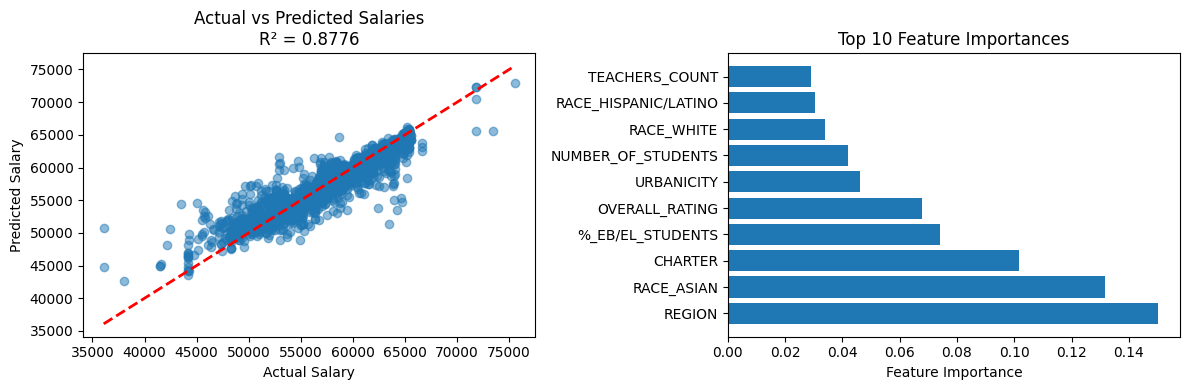


Final Recommendation: XGBoost is the optimal model for teacher salary prediction
- Achieves R² of 0.8776, explaining 87.8% of variance in salaries
- RMSE of $1,751.22 represents reasonable prediction accuracy
- Model is computationally efficient and suitable for deployment
- Feature importance provides actionable insights for salary policy decisions


In [16]:
# CELL 9: Final Visualization and Conclusion
"""
Conclusion and Recommendation:

XGBoost provides an optimal solution for predicting teacher salaries with:
- Strong predictive performance (high R², low RMSE)
- Good generalization (minimal gap between CV and test scores)
- Computational efficiency suitable for production use
- Interpretability through feature importance
- Robustness to outliers and non-linear relationships

The model successfully captures the complex relationships between school district
characteristics and teacher compensation, making it suitable for practical use
in salary planning and budgeting decisions.
"""

# Visualization
plt.figure(figsize=(12, 4))

# Plot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title(f'Actual vs Predicted Salaries\nR² = {r2:.4f}')

# Plot 2: Top Feature Importance
plt.subplot(1, 2, 2)
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances')

plt.tight_layout()
plt.show()

print(f"\nFinal Recommendation: XGBoost is the optimal model for teacher salary prediction")
print(f"- Achieves R² of {r2:.4f}, explaining {r2*100:.1f}% of variance in salaries")
print(f"- RMSE of ${rmse:,.2f} represents reasonable prediction accuracy")
print(f"- Model is computationally efficient and suitable for deployment")
print(f"- Feature importance provides actionable insights for salary policy decisions")